In [1]:
%load_ext autoreload
%autoreload 2

In [408]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
import sklearn
#sns.set_style("whitegrid")
#sns.set_palette("deep")
plt.style.use("seaborn-whitegrid")
from sklearn.model_selection import GridSearchCV
import catboost as catb
import lightgbm as lgb

from plot_mean_foehn_conditions import calculate_stability, plot_mean_foehn_condition_for_one_model, generate_coordinates_from_feature_label
from utils import calc_pot_temp

# Define constants

In [3]:
LATS_CESM_STRING = ['4287', '4382', '4476', '4570', '4664', '4759', '4853', '4947']
LONS_CESM_STRING = ['0', '125', '250', '375', '500', '625', '750', '875', '1000', '1125', '1250', '1375', '1500']

MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"]

# Read ERA data

In [4]:
df_ERA_raw = pd.read_csv("data/MeteorologicalData/ERAI_data.csv.gz", parse_dates=["date"])

In [5]:
df_ERA = df_ERA_raw.copy()

# Load CESM data 

In [8]:
df_CESMp = pd.read_csv("data/MeteorologicalData/CESM_present_day.csv.gz")
df_CESMp["date"] = pd.to_datetime(df_CESMp["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format
CESMp_features = set(df_CESMp.columns)

In [10]:
df_CESMf = pd.read_csv("data/MeteorologicalData/CESM_future_day.csv.gz")
df_CESMf["date"] = pd.to_datetime(df_CESMf["date"], format="%Y-%m-%dT%H:%M:00.000000Z") # Due to Dataiku date format
CESMf_features = set(df_CESMf.columns)

In [11]:
# Calculate and append the stability parameters
df_CESMp = calculate_stability(df = df_CESMp, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)
df_CESMf = calculate_stability(df = df_CESMf, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)

# Create pot. temp features for CESMp
df_T= df_CESMp.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMp.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMp.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMp = pd.concat([df_CESMp, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

# Create pot. temp features for CESMf
df_T= df_CESMf.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T, p = 900.0)
df_T= df_CESMf.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T, p = 850.0)
df_T= df_CESMf.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T, p = 700.0)
df_CESMf = pd.concat([df_CESMf, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

del df_PHIT_900, df_PHIT_850, df_PHIT_700

Pressure lvl doesnt exist (700-900 hPa, 4287, 0)
Pressure lvl doesnt exist (850-900 hPa, 4287, 0)
Pressure lvl doesnt exist (700-900 hPa, 4287, 125)
Pressure lvl doesnt exist (850-900 hPa, 4287, 125)
Pressure lvl doesnt exist (700-900 hPa, 4382, 250)
Pressure lvl doesnt exist (850-900 hPa, 4382, 250)
Pressure lvl doesnt exist (700-900 hPa, 4382, 375)
Pressure lvl doesnt exist (850-900 hPa, 4382, 375)
Pressure lvl doesnt exist (700-900 hPa, 4382, 500)
Pressure lvl doesnt exist (850-900 hPa, 4382, 500)
Pressure lvl doesnt exist (700-900 hPa, 4476, 250)
Pressure lvl doesnt exist (850-900 hPa, 4476, 250)
Pressure lvl doesnt exist (700-900 hPa, 4476, 375)
Pressure lvl doesnt exist (850-900 hPa, 4476, 375)
Pressure lvl doesnt exist (700-900 hPa, 4476, 500)
Pressure lvl doesnt exist (850-900 hPa, 4476, 500)
Pressure lvl doesnt exist (700-900 hPa, 4476, 625)
Pressure lvl doesnt exist (850-900 hPa, 4476, 625)
Pressure lvl doesnt exist (700-900 hPa, 4476, 750)
Pressure lvl doesnt exist (850-900 

# Use only features which are also in CESM and which are not in the Alps

In [15]:
# Only allow features which also exist in CESM
intersecting_features = list(CESMp_features.intersection(CESMf_features).intersection(set(df_ERA.columns)))
df_ERA = df_ERA[intersecting_features]

In [16]:
# Cut Alps as an rectangle and drop those features
lat_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(4570|4664|4759)\w+")).columns)
lon_features_to_cut = set(df_ERA.loc[0:1,:].filter(regex=("\w+(500|625|750|875|1000|1125|1250)\w+")).columns)

intersecting_features = lat_features_to_cut.intersection(lon_features_to_cut)

df_ERA.drop(intersecting_features, axis=1, inplace=True)

In [17]:
df_ERA

,Z_4570_250_850,T_4759_375_500,SLP_4476_1125_sealevel,V_4287_500_500,T_4382_1000_700,date,V_4382_375_500,U_4947_1375_850,Z_4382_625_700,T_4287_0_500,...,T_4382_1000_900,SLP_4476_1500_sealevel,U_4382_1375_500,V_4476_750_700,Z_4382_1500_500,V_4759_0_700,U_4759_125_700,SLP_4570_250_sealevel,V_4287_0_850,Z_4287_1000_500
0,1428.830322,-25.417286,1005.414551,-25.955097,-13.807091,1980-01-01 00:00:00,-22.613811,10.951015,2918.094482,-20.383833,...,1.466291,1001.598389,1.685929,-11.022356,5247.988770,-3.518925,8.785936,1016.596436,0.607212,5345.068848
1,1396.125000,-25.699408,1005.698120,-16.986437,-14.664779,1980-01-01 06:00:00,-15.704857,14.397406,2895.453369,-22.346487,...,2.928966,1004.183594,15.894905,-2.167594,5270.890625,-6.639442,5.701469,1012.875549,-1.543625,5390.799316
2,1400.345947,-26.399124,1006.960876,-14.600096,-12.937834,1980-01-01 12:00:00,-15.620731,13.665522,2898.425049,-24.926945,...,1.659121,1007.004150,21.740173,-2.214995,5310.066406,-10.024279,9.119905,1012.437622,-10.343779,5409.619141
3,1405.086304,-30.186077,1007.070007,-13.630262,-11.794547,1980-01-01 18:00:00,-15.251237,11.921850,2899.040039,-21.272278,...,1.668266,1007.842407,20.720173,-4.794226,5339.282227,-7.512577,8.614753,1013.310303,-8.410406,5411.222168
4,1400.802368,-33.999508,1006.975525,-20.426104,-12.429347,1980-01-02 00:00:00,-19.341368,12.221110,2900.334717,-21.412544,...,0.917027,1007.700867,20.561712,-4.429785,5335.688965,-13.626897,6.001596,1013.459290,-9.030858,5400.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57947,1570.659790,-10.853592,1016.831604,-3.432867,5.746613,2019-08-30 18:00:00,-4.410199,-1.258471,3188.753906,-12.183454,...,22.490288,1017.571960,0.565665,-1.316541,5853.248535,-3.020643,1.406120,1017.954834,-2.264621,5861.224609
57948,1556.802124,-10.584322,1017.772034,1.019960,4.933475,2019-08-31 00:00:00,-1.045981,-2.814757,3180.119629,-11.852722,...,21.496777,1017.804688,-0.608588,2.507503,5845.389160,4.205326,1.012771,1017.322083,0.793848,5847.139160
57949,1538.920654,-10.983143,1016.628174,-2.791221,4.698206,2019-08-31 06:00:00,-4.220116,-4.174884,3177.177246,-12.638944,...,21.282320,1016.680298,-3.401382,1.749228,5832.018066,5.097932,9.733367,1016.058105,-0.154327,5828.280273
57950,1537.177124,-11.312984,1015.279968,-1.960574,4.912956,2019-08-31 12:00:00,-2.493766,-2.971830,3164.862793,-11.607520,...,20.742607,1015.344666,-0.812618,3.219149,5832.452637,7.032426,9.592925,1014.808044,-1.622149,5825.624023


# Calculate derived variables

In [18]:
# Sealevel pressure differences
df_pressures = df_ERA.filter(regex=("SLP_\w+"))

pressure_list = sorted(df_pressures.columns.tolist())
pressure_list_dummy = sorted(df_pressures.columns.tolist())

SLP_dict = {}
for col1 in pressure_list:
    pressure_list_dummy.remove(col1)
    for col2 in pressure_list_dummy:
        SLP_dict[f"diff_{col1}_{col2}"] = (df_pressures.loc[:, col1] - df_pressures.loc[:, col2]).values

#df_pressures = pd.concat([df_pressures, pd.DataFrame(SLP_dict)], axis = 1)
df_pressures = pd.DataFrame(SLP_dict)

del SLP_dict

In [19]:
# Geopotential height (on 850 and 700 hPa)

df_Z = df_ERA.filter(regex=("Z_\w+"))
Z_dict = {}

for level in ["850", "700"]:
    df_Z_level = df_Z.filter(regex=("Z_\w+" + level))

    Z_list = sorted(df_Z_level.columns.tolist())
    Z_list_dummy = sorted(df_Z_level.columns.tolist())

    for col1 in Z_list:
        Z_list_dummy.remove(col1)
        for col2 in Z_list_dummy:
            Z_dict[f"diff_{col1}_{col2}"] = (df_Z_level.loc[:, col1] - df_Z_level.loc[:, col2]).values

#df_Z = pd.concat([df_Z, pd.DataFrame(Z_dict)], axis = 1)
df_Z = pd.DataFrame(Z_dict)

del df_Z_level, Z_dict

In [20]:
# Vertical potential temperature differences (on 850 hPa)

df_T = df_ERA.filter(regex=("T_\w+850"))
df_PHIT = calc_pot_temp(T=df_T+273.15, p=850.0).add_prefix("PHI")
PHIT_dict = {}

PHIT_list = sorted(df_PHIT.columns.tolist())
PHIT_list_dummy = sorted(df_PHIT.columns.tolist())

for col1 in PHIT_list:
    PHIT_list_dummy.remove(col1)
    for col2 in PHIT_list_dummy:
        PHIT_dict[f"diff_{col1}_{col2}"] = (df_PHIT.loc[:, col1] - df_PHIT.loc[:, col2]).values

#df_PHIT = pd.concat([df_PHIT, pd.DataFrame(PHIT_dict)], axis = 1)
df_PHIT = pd.DataFrame(PHIT_dict)

del df_T, PHIT_dict

In [21]:
# Stability variables

df_T= df_ERA.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T+273.15, p = 900.0)
df_T= df_ERA.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T+273.15, p = 850.0)
df_T= df_ERA.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T+273.15, p = 700.0)


stability_dict = {}
for lat in LATS_CESM_STRING:
    for lon in LONS_CESM_STRING:
        try:
            stability_dict[f"DELTAPHI_{lat}_{lon}_850"] = (df_PHIT_850.loc[:, f"PHIT_{lat}_{lon}_850"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
            stability_dict[f"DELTAPHI_{lat}_{lon}_700"] = (df_PHIT_700.loc[:, f"PHIT_{lat}_{lon}_700"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
        except:
            print("Variable does not exist at this location.")
df_stability = pd.DataFrame(stability_dict)

del df_T, df_PHIT_900, df_PHIT_850, df_PHIT_700, stability_dict

Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this location.
Variable does not exist at this lo

In [22]:
# Wind velocities
df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()

In [23]:
df_ERA = pd.concat([df_ERA["date"], 
                     df_pressures, 
                     df_Z, 
                     df_PHIT, 
                     df_stability, 
                     df_wind], 
                    axis = 1)

# Merge in foehn data at specified location

In [169]:
location="LUG"
df_foehn_raw = pd.read_csv(f"data/FoehnData/{location}_foehn.csv", parse_dates=["date"])
df_foehn_raw.dropna(inplace=True, how="any", axis=0)

# Merge ERAI and foehn data
df_ERA_all_features = pd.merge(df_foehn_raw, df_ERA, on="date", how="inner")

# Drop rows with missing foehn  values
# df_ERA_all_features.dropna(inplace=True, how="any", axis=0)
# df_ERA_all_features.reset_index(inplace=True, drop=True)

# Train Model on full data

In [29]:
# Create train and test mask
test_mask = (df_ERA_all_features["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA_all_features["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [30]:
# Create list of all features for prediction
feature_names=df_ERA_all_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

In [31]:
def fit_clf_on_all_features(model, df_ERA, feature_names):
    
    # Fit model
    model.fit(df_ERA.loc[train_mask, feature_names], 
              df_ERA.loc[train_mask, "Foehn"])
    
    # Make predictions
    predictions = model.predict_proba(df_ERA.loc[test_mask, feature_names])
    
    # Calculate best threshold
    precisions, recalls, thresholds = precision_recall_curve(df_ERA.loc[test_mask, "Foehn"], predictions[:,1])
    best_threshold = thresholds[np.argmin(abs(precisions-recalls))]
    predictions = (predictions[:,1]>best_threshold).astype(int)
    
    # Plot precision and recall curves
    f = plt.figure(figsize=(12,5))
    f.add_subplot(121)
    sns.lineplot(precisions, recalls)
    f.add_subplot(122)
    sns.lineplot(np.append(thresholds, 1.0), precisions)
    sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print best threshold, precision, recall and confusion matrix
    print(f"Best threshold: {best_threshold}")
    print(f'Precision: {precision_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(f'Recall: {recall_score(df_ERA.loc[test_mask, "Foehn"], predictions)}')
    print(confusion_matrix(df_ERA.loc[test_mask, "Foehn"], predictions))
    
    # Show 50 most important features
    df_ERA_feature_importances = pd.DataFrame({"feature_name": feature_names, "importance": model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True)
    display(df_ERA_feature_importances.head(50))
    
    return df_ERA_feature_importances

In [ ]:
# model_cat = catb.CatBoostClassifier(loss_function='Logloss',
#                                 verbose=True,
#                                 scale_pos_weight=20,
#                                 thread_count=20,
#                                 max_depth=4, 
#                                 learning_rate=0.1, 
#                                 n_estimators=1000,
#                                 reg_lambda=10,
#                                    random_state=42)

# df_ERA_feature_importances = fit_clf_on_all_features(model_cat, df_ERA_all_features, feature_names)

[12:16:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:16:14] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:16:17] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:16:20] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:16:23] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:16:28] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=4
[12:16:32] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[12:16:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:16:39] INFO: /workspace/src/tree/upd

[12:20:03] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:20:06] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=4
[12:20:10] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[12:20:13] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[12:20:16] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:20:19] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[12:20:22] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[12:20:25] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=4
[12:20:28] INFO: /workspace/src/tree/upd

[12:23:35] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:23:38] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:23:41] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=4
[12:23:44] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=4
[12:23:48] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:23:51] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:23:54] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=4
[12:23:57] INFO: /workspace/src/tree/updater_prune.cc:98: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=4
[12:24:00] INFO: /workspace/src/tree/upd

,feature_name,importance
0,diff_Z_4476_1250_850_Z_4664_375_850,0.162663
1,diff_Z_4476_1375_850_Z_4570_375_850,0.159639
2,diff_Z_4570_1375_850_Z_4664_375_850,0.158114
3,diff_Z_4476_1250_850_Z_4570_375_850,0.061518
4,diff_Z_4570_1375_850_Z_4570_375_850,0.040162
5,diff_Z_4476_1375_850_Z_4664_375_850,0.023399
6,diff_Z_4476_1500_850_Z_4570_375_850,0.017892
7,V_4476_625_850,0.009870
8,diff_SLP_4476_1125_sealevel_SLP_4853_875_sealevel,0.009553
9,diff_PHIT_4476_1000_850_PHIT_4853_875_850,0.009436


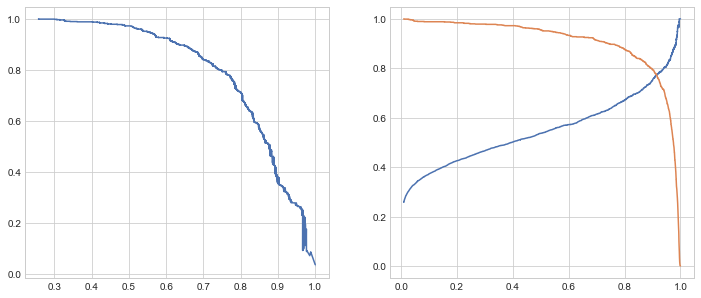

In [32]:
# Fit a global classifier on all features
model_xg = xgb.XGBClassifier(
                    max_depth=4,
                    learning_rate=0.1,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=100.0,
                    reg_lambda=1.0,
                    n_estimators=200,
                    verbosity=2,
                    nthread=20,
                    scale_pos_weight=20.0,
                    base_score=0.2,
                    seed=1337,
                    missing=None,
                  )
df_ERA_feature_importances = fit_clf_on_all_features(model_xg, df_ERA_all_features, feature_names)

# Reduce dataframe to most important features

In [198]:
df_ERA_reduced_features = df_ERA_all_features.loc[:,df_ERA_feature_importances.loc[:200, "feature_name"]]
feature_names_reduced = df_ERA_reduced_features.columns.tolist()
df_ERA_reduced_features["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features["Foehn"] = df_ERA_all_features["Foehn"]

# Transform features to quantiles on ERA

In [199]:
quantile_scaler_ERA = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_ERA.fit(df_ERA_reduced_features.loc[train_mask, feature_names_reduced]) # Only fit on training data

df_ERA_reduced_features_scaled = pd.DataFrame(quantile_scaler_ERA.transform(df_ERA_reduced_features.loc[:, feature_names_reduced]), 
                                              columns = feature_names_reduced, 
                                              index=df_ERA_reduced_features.index)
df_ERA_reduced_features_scaled["date"] = df_ERA_all_features["date"]
df_ERA_reduced_features_scaled["Foehn"] = df_ERA_all_features["Foehn"]

# Generate and preprocess CESM features

In [200]:
# Create features which are used by the simplified model
feature_dict_CESMp = {}
feature_dict_CESMf = {}
for feature_name in feature_names_reduced:
    if feature_name[0:6] == "diff_S":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_Z":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "diff_P":
        feature_name_splitted = feature_name.split("_")
        first_feature = "_".join(feature_name_splitted[1:5])
        second_feature = "_".join(feature_name_splitted[5:9])
        
        feature_dict_CESMp[f"diff_{first_feature}_{second_feature}"] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf[f"diff_{first_feature}_{second_feature}"] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values

    elif feature_name[0:6] == "DELTAP":
        feature_name_splitted = feature_name.split("_")
        first_feature = "PHIT_" + "_".join(feature_name_splitted[1:4])
        second_feature = "PHIT_" + "_".join(feature_name_splitted[1:3]) + "_900"
        
        feature_dict_CESMp["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMp.loc[:, first_feature] - df_CESMp.loc[:, second_feature]).values
        feature_dict_CESMf["DELTAPHI_" +"_".join(feature_name_splitted[1:4])] = (df_CESMf.loc[:, first_feature] - df_CESMf.loc[:, second_feature]).values
    
    else:
        feature_dict_CESMp[feature_name] = df_CESMp.loc[:, feature_name].values
        feature_dict_CESMf[feature_name] = df_CESMf.loc[:, feature_name].values

feature_dict_CESMp["date"] =df_CESMp.loc[:, "date"].values
feature_dict_CESMf["date"] =df_CESMf.loc[:, "date"].values

feature_dict_CESMp["ensemble"] =df_CESMp.loc[:, "ensemble"].values
feature_dict_CESMf["ensemble"] =df_CESMf.loc[:, "ensemble"].values

df_CESMp_reduced_features = pd.DataFrame(feature_dict_CESMp)
df_CESMf_reduced_features = pd.DataFrame(feature_dict_CESMf)

In [201]:
quantile_scaler_CESM = QuantileTransformer(subsample=10**(6), random_state=42)
quantile_scaler_CESM.fit(df_CESMp_reduced_features.loc[:, feature_names_reduced])

df_CESMp_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMp_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMp_reduced_features.loc[:, feature_names_reduced].index)

df_CESMf_reduced_features_scaled = pd.DataFrame(quantile_scaler_CESM.transform(df_CESMf_reduced_features.loc[:, feature_names_reduced]), 
                                                columns = feature_names_reduced, 
                                                index=df_CESMf_reduced_features.loc[:, feature_names_reduced].index)

df_CESMp_reduced_features_scaled["date"] = df_CESMp_reduced_features["date"]
df_CESMf_reduced_features_scaled["date"] = df_CESMf_reduced_features["date"]

df_CESMp_reduced_features_scaled["ensemble"] = df_CESMp_reduced_features["ensemble"]
df_CESMf_reduced_features_scaled["ensemble"] = df_CESMf_reduced_features["ensemble"]

# Fit XGBoost to reduced feature set & evaluate

In [202]:
# def plot_metrics_by_month(precision_scores, recall_scores, f1_scores):
#     plt.figure(figsize=(16,9))
#     plt.plot(MONTH_NAMES, precision_scores)
#     plt.plot(MONTH_NAMES, recall_scores)
#     plt.plot(MONTH_NAMES, f1_scores)
#     plt.legend(["precision", "recall", "f1-score"])

In [203]:
# def get_best_model_through_CV(model, parameters_CV):
#     # Fit model
#     model_CV = GridSearchCV(model, parameters_CV, cv=3, n_jobs=5, scoring='neg_log_loss')
#     model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced], 
#                  df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"])
#     print(model_CV.best_params_)
    
#     # Predict and optimize threshold
#     best_model = model_CV.best_estimator_
#     df_ERA_reduced_features_scaled.loc[:, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[:, feature_names_reduced])[:,1]
#     precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], 
#                                                              df_ERA_reduced_features_scaled.loc[test_mask, "prediction_proba"])
#     best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
#     df_ERA_reduced_features_scaled.loc[:, "prediction"] = (df_ERA_reduced_features_scaled.loc[:, "prediction_proba"]> best_threshold_ERA).astype(int)
    
#     # Plot model evaluation curves
# #     f = plt.figure(figsize=(12,5))
# #     f.add_subplot(121)
# #     sns.lineplot(precisions, recalls)
# #     f.add_subplot(122)
# #     sns.lineplot(np.append(thresholds, 1.0), precisions)
# #     sns.lineplot(np.append(thresholds, 1.0), recalls)
    
#     # Print model evaluation scores
    
#     df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]
#     print(f"Best threshold: {best_threshold_ERA}")
#     print(f'Precision: {precision_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
#     print(f'Recall: {recall_score(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"])}')
#     print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask, "prediction"]))
#     display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
    
#     precision_scores, recall_scores, f1_scores = [], [], []
#     for month in range(1,12+1):
#         test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
#         precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1score)

#     plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
    
   
#     return best_model, best_threshold_ERA

In [204]:
# from sklearn.model_selection import cross_validate

# def train_model_for_each_month(model, parameters):
#     models_retrained_list, thresholds_list = [], []
    
#     precision_scores, recall_scores, f1_scores = [], [], []
    
#     plt.figure(figsize=(16,9))
#     for month in range(1,12+1):
#         # Define train and test masks
#         train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
#         test_mask_month =  test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
#         all_mask_month =  (df_ERA_reduced_features_scaled["date"].dt.month == month)
        
#         # CV
# #         model.set_params(scale_pos_weight=df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].count()/df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"].sum())
# #         print(model.get_params())
#         model_CV = GridSearchCV(model, parameters, cv=[(slice(None), slice(None))], n_jobs=4, scoring=custom_metric_for_month, verbose=1)
#         model_CV.fit(df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced], 
#                      df_ERA_reduced_features_scaled.loc[train_mask_month, "Foehn"])
#         print(model_CV.cv_results_["mean_test_score"])
#         # Get feature importance
# #         print(dict(zip(feature_names_reduced, model_CV.best_estimator_.feature_importances_)))
        
#         # Optimize threshold
#         best_model = model_CV.best_estimator_
#         df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"] = best_model.predict_proba(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced])[:,1]
#         precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
#                                                                  df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
#         best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
#         df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction"] = (df_ERA_reduced_features_scaled.loc[all_mask_month, "prediction_proba"]>best_threshold_ERA).astype(int)
        
#         # Print model evaluation scores
#         precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1score)
        
#         print(f"Best threshold: {best_threshold_ERA}")
#         print(f'Precision: {precision}')
#         print(f'Recall: {recall}')
#         print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
#         display(pd.DataFrame({"feature_name": feature_names_reduced, "importance": best_model.feature_importances_}).sort_values(by="importance", ascending=False).reset_index(drop=True).head(10))
        
#         # Retrain model on full data
#         best_model.fit(df_ERA_reduced_features_scaled.loc[all_mask_month, feature_names_reduced], 
#                        df_ERA_reduced_features_scaled.loc[all_mask_month, "Foehn"])
#         models_retrained_list.append(best_model)
#         thresholds_list.append(best_threshold_ERA)
        
#     plot_metrics_by_month(precision_scores, recall_scores, f1_scores)
#     return models_retrained_list, thresholds_list

In [380]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def custom_loss(predt: np.ndarray, dtrain: xgb.DMatrix, ERA_len, CESM_len, alpha=30000):
    y = dtrain.get_label()[:ERA_len]
    
    pred = sigmoid(predt)
    pred_ERA = pred[:ERA_len]
    pred_CESM = pred[ERA_len:]
    
    grad_logloss  = pred_ERA - y
    hess_logloss = pred_ERA*(1.0 - pred_ERA)
    
    grad_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y))
    hess_custom = 2*alpha/CESM_len*pred_CESM*(1-pred_CESM)*((1-pred_CESM)*(np.mean(pred_CESM)-np.mean(y)) -
                                                            pred_CESM*(np.mean(pred_CESM)-np.mean(y)) +
                                                            pred_CESM*(1-pred_CESM)/CESM_len
                                                            )
    
    grad = np.zeros(len(predt))
    grad[:ERA_len] = grad_logloss
    grad[ERA_len:] = grad_custom
    
    hess = np.zeros(len(predt))
    hess[:ERA_len] = hess_logloss
    hess[ERA_len:] = hess_custom
    
    return grad, hess

# def custom_metric_for_month(estimator, X, y):
#     month_mask_ERA_custom_metric = (df_ERA_reduced_features_scaled["date"].dt.month == month)
#     month_mask_CESMp_custom_metric = (df_CESMp_reduced_features_scaled["date"].dt.month == month)
    
#     prediction_probas_ERA = estimator.predict_proba(X)[:,1]
#     precisions, recalls, thresholds = precision_recall_curve(y, prediction_probas_ERA)
#     best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]                                                         
    
#     foehn_truth = df_ERA_reduced_features_scaled.loc[month_mask_ERA_custom_metric, "Foehn"]
#     CESMp_predictions = (estimator.predict_proba(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp_custom_metric, feature_names_reduced]) >best_threshold_ERA).astype(int)
    
    
    
    
#     return -np.square(np.mean(CESMp_predictions)-np.mean(foehn_truth))

In [381]:
monthly_models = 1

params = {'max_depth': 4, 'learning_rate': 0.2, "reg_alpha":1, "reg_lambda":10, "n_jobs": 25,"verbosity":1, "seed": 0}

models_retrained_list, thresholds_list = [], []
precision_scores, recall_scores, f1_scores= [], [], []

most_important_features = dict()


# Train first on all data
D_train = xgb.DMatrix(df_ERA_reduced_features_scaled.loc[train_mask, feature_names_reduced],
                      label=df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"], 
                      weight=df_ERA_reduced_features_scaled.loc[train_mask, "Foehn"]*20+1)
model_ges = xgb.Booster(params, [D_train])
model_ges = xgb.train(params, dtrain = D_train, num_boost_round=10, xgb_model=model_ges)

print("Done Fitting on whole Dataset")

total_confusion_matrix= np.zeros((2,2))

for month in range(1,12+1):
    print(MONTH_NAMES[month-1])
    
    # Define masks to address specific parts of data set
    # ERA masks
    train_mask_month = train_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
    test_mask_month = test_mask & (df_ERA_reduced_features_scaled["date"].dt.month == month)
    month_mask_ERA = (df_ERA_reduced_features_scaled["date"].dt.month == month)
    
    month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month)

    # Build training dataset from ERA and CESMp
    df_ERA_CESMp = pd.concat([df_ERA_reduced_features_scaled.loc[train_mask_month, feature_names_reduced + ["Foehn"]], 
                              df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced]],
                            axis=0)
    
    
    D_train = xgb.DMatrix(df_ERA_CESMp[feature_names_reduced], label=df_ERA_CESMp["Foehn"], weight=(df_ERA_CESMp["Foehn"]*20+1))
    
    # Train model
    #model = xgb.Booster(params, [D_train])
    model = model_ges.copy()
    for _ in range(100):
        pred = model.predict(D_train)
        g, h = custom_loss(pred, D_train, ERA_len=train_mask_month.sum(), CESM_len = month_mask_CESMp.sum())
        model.boost(D_train, g, h)
    
    
    # Make prediction on whole data
    D_total = xgb.DMatrix(df_ERA_reduced_features_scaled.loc[month_mask_ERA, feature_names_reduced])
    yhat = sigmoid(model.predict(D_total))
    
    
    df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction_proba"] = yhat
    
    # Calculate metrics on test set & identify best threshold
    precisions, recalls, thresholds = precision_recall_curve(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], 
                                                             df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction_proba"])
    best_threshold_ERA = thresholds[np.argmin(abs(precisions-recalls))]
    thresholds_list.append(best_threshold_ERA)
    
    # Make final prediciton for ERA
    df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction"] = (df_ERA_reduced_features_scaled.loc[month_mask_ERA, "prediction_proba"]>best_threshold_ERA).astype(int)

    # Print model evaluation scores
    precision = precision_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    recall = recall_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    f1score = f1_score(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1score)
    total_confusion_matrix += confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"])


    print(f"Best threshold: {best_threshold_ERA}")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(confusion_matrix(df_ERA_reduced_features_scaled.loc[test_mask_month, "Foehn"], df_ERA_reduced_features_scaled.loc[test_mask_month, "prediction"]))
    
    importances_month = pd.DataFrame.from_dict(model.get_score(importance_type='gain'), orient="index", columns=["importance"]).sort_values(by="importance", ascending=False)
    #display(importances_month.head(10))
    
    
    for row in importances_month.head(10).iterrows():
        if row[0] in most_important_features.keys():
            most_important_features[row[0]] += row[1][0]
        else:
            most_important_features[row[0]] = row[1][0]
    
    models_retrained_list.append(model)

Done Fitting on whole Dataset
Jan
Best threshold: 0.5142527222633362
Precision: 0.75
Recall: 0.7384615384615385
[[1158   16]
 [  17   48]]
Feb
Best threshold: 0.47116392850875854
Precision: 0.7524752475247525
Recall: 0.7450980392156863
[[1005   25]
 [  26   76]]
Mar
Best threshold: 0.5054983496665955
Precision: 0.7664670658682635
Recall: 0.7619047619047619
[[1033   39]
 [  40  128]]
Apr
Best threshold: 0.5310946702957153
Precision: 0.6851851851851852
Recall: 0.6788990825688074
[[1057   34]
 [  35   74]]
May
Best threshold: 0.5451250672340393
Precision: 0.7887323943661971
Recall: 0.7777777777777778
[[1153   15]
 [  16   56]]
Jun
Best threshold: 0.4491792619228363
Precision: 0.75
Recall: 0.7377049180327869
[[1124   15]
 [  16   45]]
Jul
Best threshold: 0.40067583322525024
Precision: 0.6933333333333334
Recall: 0.6842105263157895
[[1141   23]
 [  24   52]]
Aug
Best threshold: 0.5170913934707642
Precision: 0.717948717948718
Recall: 0.7
[[1189   11]
 [  12   28]]
Sep
Best threshold: 0.527690

[[13422.   247.]
 [  259.   683.]]
Precision: 0.7344086021505376
Recall: 0.7250530785562632


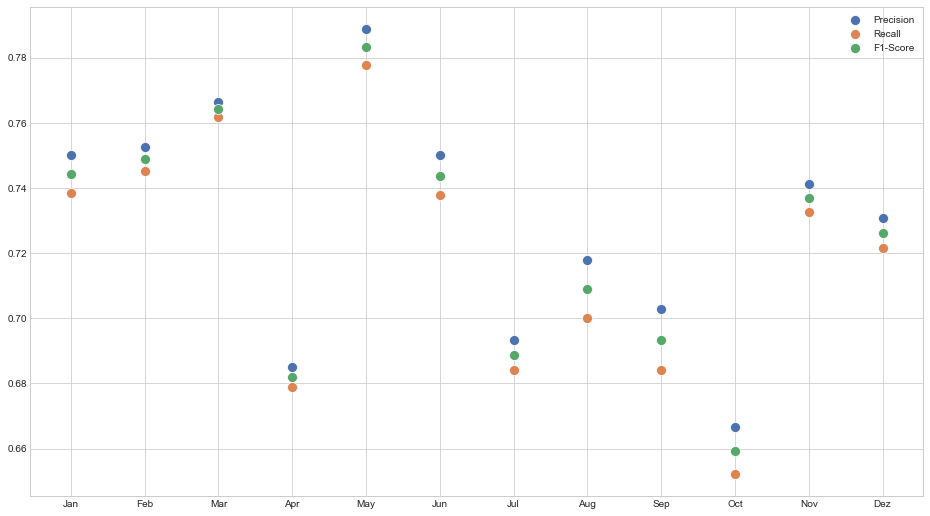

In [382]:
print(total_confusion_matrix)
print(f'Precision: {total_confusion_matrix[1,1]/total_confusion_matrix[:,1].sum()}')
print(f'Recall: {total_confusion_matrix[1,1]/total_confusion_matrix[1,:].sum()}')

plt.figure(figsize=(16,9))
sns.scatterplot(MONTH_NAMES, precision_scores, s=100)
sns.scatterplot(MONTH_NAMES, recall_scores, s=100)
sns.scatterplot(MONTH_NAMES, f1_scores, s=100)
plt.legend(["Precision", "Recall", "F1-Score"])

[[13422.   247.]
 [  259.   683.]]
Precision: 0.7344086021505376
Recall: 0.7250530785562632


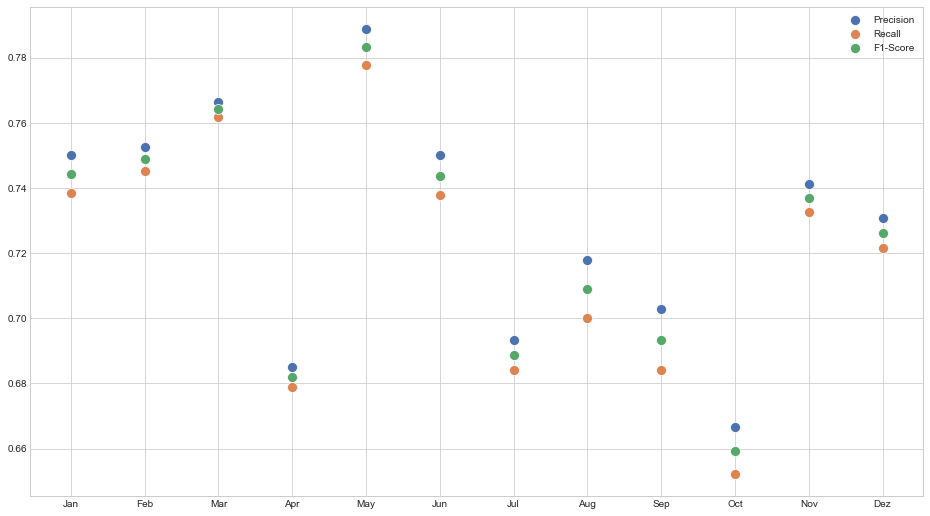

In [383]:
print(total_confusion_matrix)
print(f'Precision: {total_confusion_matrix[1,1]/total_confusion_matrix[:,1].sum()}')
print(f'Recall: {total_confusion_matrix[1,1]/total_confusion_matrix[1,:].sum()}')

plt.figure(figsize=(16,9))
sns.scatterplot(MONTH_NAMES, precision_scores, s=100)
sns.scatterplot(MONTH_NAMES, recall_scores, s=100)
sns.scatterplot(MONTH_NAMES, f1_scores, s=100)
plt.legend(["Precision", "Recall", "F1-Score"])

# Predict on CESMp and CESMf

In [384]:
if monthly_models:
    for month in range(1,12+1):
        month_mask_CESMp = (df_CESMp_reduced_features_scaled["date"].dt.month == month )
        month_mask_CESMf = (df_CESMf_reduced_features_scaled["date"].dt.month == month )
        
        xgb_CESMp = xgb.DMatrix(df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, feature_names_reduced])
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMp))
        df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction"] = (df_CESMp_reduced_features_scaled.loc[month_mask_CESMp, "prediction_proba"]> thresholds_list[month-1]).astype(int)
        
        xgb_CESMf = xgb.DMatrix(df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, feature_names_reduced])
        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"] = sigmoid(models_retrained_list[month-1].predict(xgb_CESMf))
        df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction"] = (df_CESMf_reduced_features_scaled.loc[month_mask_CESMf, "prediction_proba"]> thresholds_list[month-1]).astype(int)
                                                 
df_CESMp_reduced_features_scaled["dataset"] = "CESMp"
df_CESMf_reduced_features_scaled["dataset"] = "CESMf"

# Concenate all dataframes

In [385]:
# Create dataframe for actually observed foehn cases 
df_foehn = df_ERA_reduced_features_scaled.loc[:, ["date", "Foehn"]]
df_foehn["dataset"] = "observed_foehn"
df_foehn["ensemble"] = "observed_foehn"
df_foehn.rename({"Foehn": "prediction"}, axis=1, inplace=True)

In [386]:
df_ERA_reduced_features_scaled["dataset"] = "ERA"
df_ERA_reduced_features_scaled["ensemble"] = "ERA"

In [387]:
# Concat all observed foehn, ERAI, CESMp and CESMf prediction
df_foehn_ERA_CESMp_CESMf = pd.concat([df_foehn, 
                                      df_ERA_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]], 
                                      df_CESMp_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]], 
                                      df_CESMf_reduced_features_scaled[["date", "prediction", "dataset", "ensemble"]]], 
                                     axis=0, 
                                     ignore_index=True)

In [388]:
# Might be necessary to transform type of date column (should not)
# df_foehn_ERA_CESMp_CESMf["date"] = pd.to_datetime(df_foehn_ERA_CESMp_CESMf["date"], utc=True)

In [389]:
# Create month and year column
df_foehn_ERA_CESMp_CESMf["month"] = df_foehn_ERA_CESMp_CESMf["date"].dt.month
df_foehn_ERA_CESMp_CESMf["year"] = df_foehn_ERA_CESMp_CESMf["date"].dt.year

In [390]:
# Group dataframe by dataset, ensemble, year, month, and prediction and calculate mean
df_monthly_mean = df_foehn_ERA_CESMp_CESMf[["date", "year", "month", "dataset", "ensemble", "prediction"]].groupby(["dataset", "ensemble", "year", "month"], axis=0, as_index=False).mean()

In [391]:
# Retrieve the test period (1991 until 2000) and future prediction (2091-2100)
test_mask_final_plot = ((1990< df_monthly_mean["year"]) & (df_monthly_mean["year"]<2001)) | (2090< df_monthly_mean["year"])
df_monthly_mean_testset = df_monthly_mean[test_mask_final_plot]

# Create Plots

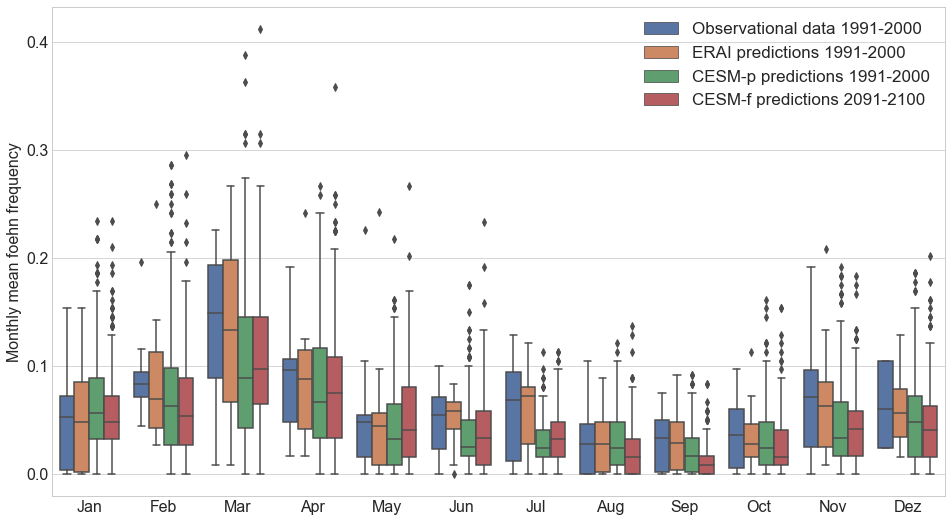

In [425]:
# Plot boxplot for mean foehn frequencies for all datasets
plt.figure(figsize=(16,9))
fig = sns.boxplot(x="month", y="prediction", data=df_monthly_mean_testset, hue="dataset", hue_order=["observed_foehn", "ERA", "CESMp", "CESMf"])
fig.set_xticklabels(MONTH_NAMES);
plt.xlabel("")
plt.ylabel("Monthly mean foehn frequency")
plt.rcParams.update({'font.size': 17})
handles, labels = fig.get_legend_handles_labels()
labels = ["Observational data 1991-2000", "ERAI predictions 1991-2000", "CESM-p predictions 1991-2000", "CESM-f predictions 2091-2100" ]
fig.legend(handles, labels)


# Second statistical test

(0.0, 0.18)

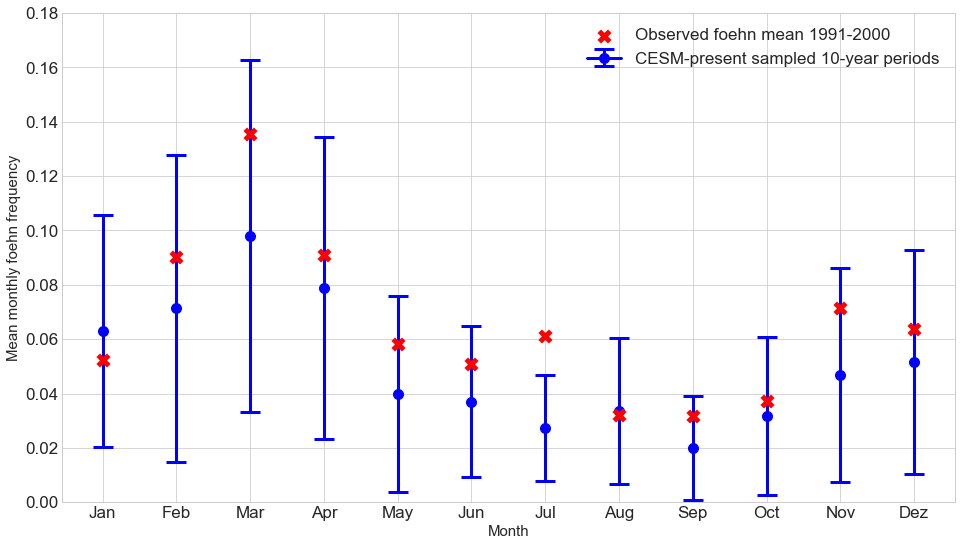

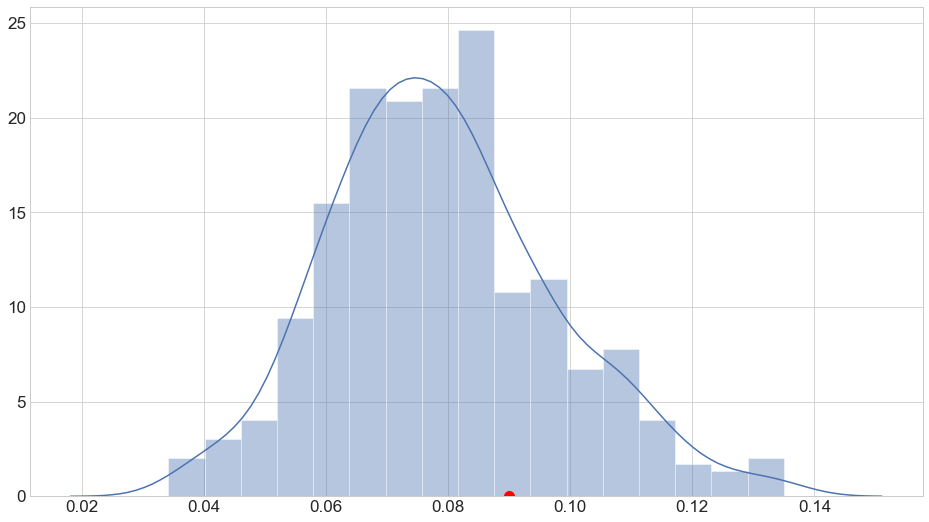

In [427]:
plt.figure(figsize=(16,9))
ax = plt.axes()

for month_test in range(1, 12+1):
    plt.figure(1)
    CESM_test_distribution = []
    df_CESMp_monthly = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    for i in range(500):
        CESM_test_distribution_year = []
        for year in range(1991, 2001):
            CESM_test_distribution_year.append(df_CESMp_monthly.loc[df_CESMp_monthly["year"]==year, "prediction"].sample(1))
        CESM_test_distribution.append(np.mean(CESM_test_distribution_year))
#     if month_test == 2:
#         plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
#                      yerr = np.array([[2.34*np.array(CESM_test_distribution).std(),3*np.array(CESM_test_distribution).std()]]).T, 
#                      color="b", 
#                      marker="o",
#                      markersize=10, 
#                      linewidth=3, 
#                      capsize=10, 
#                      capthick=3, 
#                      zorder=1)
#         plt.scatter(month_test, (df_sum.loc[(df_sum["original_dataset"]=="ERA") & (df_sum["month"]==month_test), "prediction"]).mean(), 
#                     marker="x", 
#                     color="r", 
#                     s=110, 
#                     linewidth=5, 
#                     zorder=10)
#     else:
    plt.errorbar(month_test, np.mean(np.array(CESM_test_distribution)), 
                 yerr = 3*np.array(CESM_test_distribution).std(), 
                 color="b", 
                 marker="o",
                 markersize=10, 
                 linewidth=3, 
                 capsize=10, 
                 capthick=3, 
                 zorder=1)
    plt.scatter(month_test, (df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="observed_foehn") & (df_monthly_mean_testset["month"]==month_test), "prediction"]).mean(), 
                marker="x", 
                color="r", 
                s=110, 
                linewidth=5, 
                zorder=10)

    if month_test==4:
        plt.figure(figsize=(16,9))
        sns.distplot(CESM_test_distribution)
        plt.plot(df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="ERA") & (df_monthly_mean_testset["month"]==month_test), "prediction"].mean(),0, 
                "ro", 
                markersize=10)
    
    if month_test==1: # To make plot prettier
        legend = ax.legend(["Observed foehn mean 1991-2000", "CESM-present sampled 10-year periods"])
        
ax.set(xticklabels=MONTH_NAMES, xticks=range(1,12+1))
ax.set_xlabel("Month",fontsize=15)
ax.set_ylabel("Mean monthly foehn frequency",fontsize=15)
ax.set_ylim((0,0.18))



# Third statistical test

In [379]:
for month_test in range(1, 12+1):
    CESMp_test_distribution = []
    CESMf_test_distribution = []
    df_CESMp_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMp") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    df_CESMf_month = df_monthly_mean_testset.loc[(df_monthly_mean_testset["dataset"]=="CESMf") & (df_monthly_mean_testset["month"]==month_test),:].reset_index()
    st, p = sci.ks_2samp(df_CESMp_month["prediction"], df_CESMf_month["prediction"])

    print(MONTH_NAMES[month_test-1] +"\t" +str(np.round(p,5)) + "\t" + str(p<0.01))

Jan	0.03223	False
Feb	0.12842	False
Mar	0.00469	True
Apr	0.33414	False
May	0.0101	False
Jun	0.2893	False
Jul	0.00034	True
Aug	9e-05	True
Sep	2e-05	True
Oct	0.03996	False
Nov	0.18091	False
Dez	0.01288	False


# Ensemble deviation

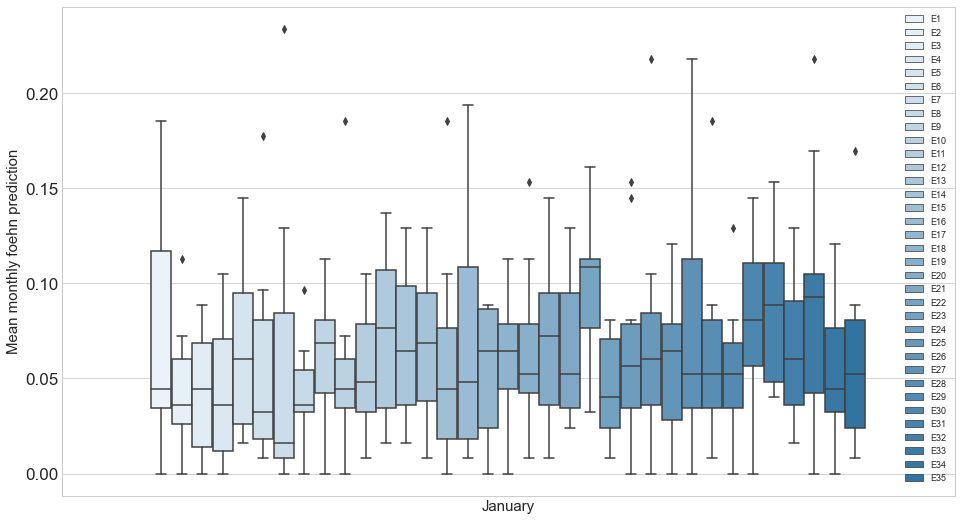

In [430]:
df_ensemble = df_foehn_ERA_CESMp_CESMf.loc[df_foehn_ERA_CESMp_CESMf["dataset"]=="CESMp"].groupby(["ensemble", "year", "month"], as_index=False).mean()

plt.figure(figsize=(16,9))
ax = sns.boxplot(x="month", y="prediction", data=df_ensemble.loc[df_ensemble["month"]==1,:], hue="ensemble", hue_order=["E"+str(i) for i in range(1,35+1)], color="tab:blue")

ax.set(xticks=[])
ax.set_xlabel("January",fontsize=15)
ax.set_ylabel("Mean monthly foehn prediction",fontsize=15)
ax.legend(fontsize=9)
# sns.set(font_scale=0.8)

# Plot weathermaps

In [251]:
df_ERA_raw_temp_adjusted = df_ERA_raw.copy()

temp_columns = df_ERA_raw_temp_adjusted.filter(regex="T_").columns
df_ERA_raw_temp_adjusted[temp_columns] = df_ERA_raw_temp_adjusted[temp_columns]+ 273.15
df_ERA_with_stability = calculate_stability(df = df_ERA_raw_temp_adjusted, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)

df_ERA_with_stability = pd.merge(df_foehn_raw, df_ERA_with_stability, on="date", how="inner")
df_ERA_raw.columns

Index(['date', 'SLP_4287_0_sealevel', 'SLP_4287_125_sealevel',
       'SLP_4287_250_sealevel', 'SLP_4287_375_sealevel',
       'SLP_4287_500_sealevel', 'SLP_4287_625_sealevel',
       'SLP_4287_750_sealevel', 'SLP_4287_875_sealevel',
       'SLP_4287_1000_sealevel',
       ...
       'V_4947_375_500', 'V_4947_500_500', 'V_4947_625_500', 'V_4947_750_500',
       'V_4947_875_500', 'V_4947_1000_500', 'V_4947_1125_500',
       'V_4947_1250_500', 'V_4947_1375_500', 'V_4947_1500_500'],
      dtype='object', length=1769)

In [432]:
variable = 'Z'

variable_lvl = {"SLP": "sealevel",
                "Z": "850",
                "T": "850",
                "DELTAPHI": "700",
                "U": "700",
                "V": "700"}

unit = {"SLP": "hPa",
        "Z": "meters",
        "T": "$^\circ$C",
        "DELTAPHI": "$^\circ$C",
        "U": "m/s",
        "V": "m/s"}


# # Altdorf
# v_limits = {"SLP": [1003, 1018],
#             "Z": [1350, 1520],
#             "T": [17+273.15, 21+273.15],
#             "DELTAPHI": [6,11],
#             "U":[5,15],
#             "V":[5,15]}

# # Piotta
# v_limits = {"SLP": [1013, 1025],#[1003, 1018],
#             "Z": [1460, 1530],#[1350, 1520],
#             "T": [-1+273.15, 6+273.15],
#             "DELTAPHI": [5.5, 12.5], #[6,11],
#             "U":[5,15],
#             "V":[5,15]}

# Lugano
v_limits = {"SLP": [1013, 1025],#[1003, 1018],
            "Z": [1460, 1530],#[1350, 1520],
            "T": [-1+273.15, 6+273.15],
            "DELTAPHI": [5.5, 12.5], #[6,11],
            "U":[5,15],
            "V":[5,15]}


df_importances = generate_coordinates_from_feature_label(most_important_features, variable)
display(df_importances)

,variable,lat1,lon1,lat2,lon2,importance
0,Z,4570,1375,4664,375,49870.276569
1,Z,4476,1375,4570,375,20971.186721
2,Z,4476,1250,4664,375,7699.482485
3,Z,4382,0,4853,1500,1102.453270
4,Z,4476,1375,4664,375,5885.943981
5,Z,4570,1375,4570,375,1024.083554
6,Z,4476,1500,4570,375,210.097460
7,Z,4570,0,4947,1500,75.383545
8,Z,4476,1500,4664,375,128.252347


Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_Z_850_OBS_SouthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_Z_850_ERA_SouthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_Z_850_CESMp_SouthFoehn.pdf'
Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_Z_850_CESMf_SouthFoehn.pdf'


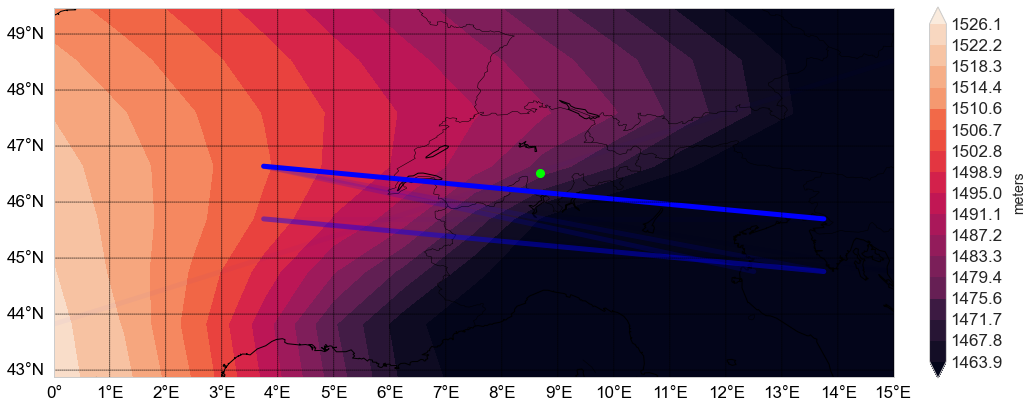

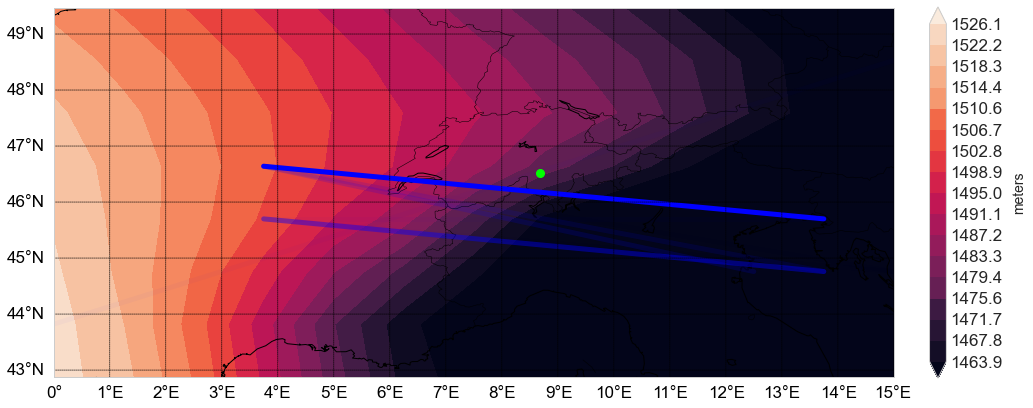

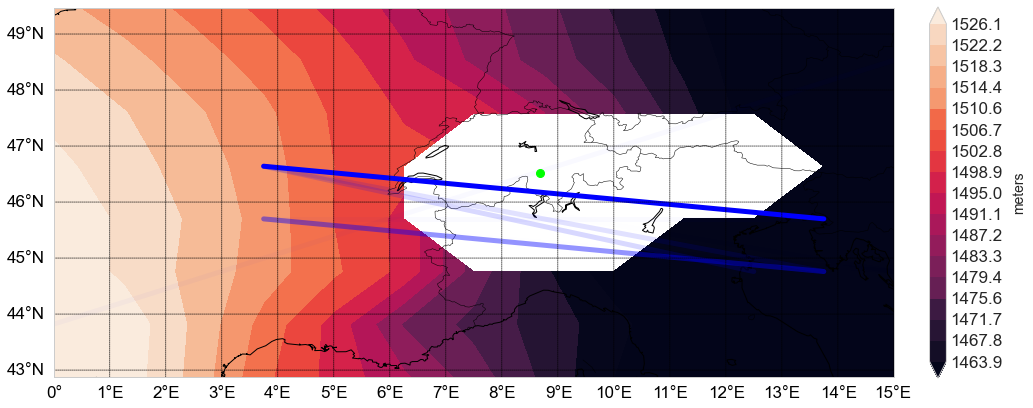

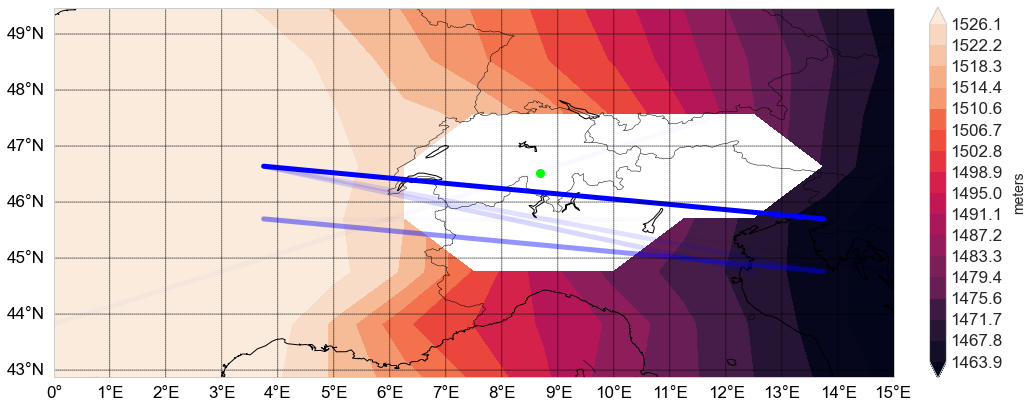

In [442]:
kwargs = {"variable": variable,
          "variable_lvl": variable_lvl[variable],
          "unit": unit[variable],
          "vmin": v_limits[variable][0],
          "vmax": v_limits[variable][1],
          "lats_labels": LATS_CESM_STRING, 
          "lons_labels": LONS_CESM_STRING, 
          "df_importances": df_importances}


month = 4
month_mask_ERA = df_ERA_with_stability["date"].dt.month == month
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= "OBS_SouthFoehn", 
                                        df = df_ERA_with_stability.loc[:,:], 
                                        foehn = df_ERA_with_stability.loc[:, "Foehn"], 
                                        )

plot_mean_foehn_condition_for_one_model(**kwargs,
                                        model= "ERA_SouthFoehn",
                                        df = df_ERA_with_stability.loc[:,:], 
                                        foehn = df_ERA_reduced_features_scaled.loc[:, "prediction"], 
                                        )

month_mask_CESMp = df_CESMp["date"].dt.month== month
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= "CESMp_SouthFoehn", 
                                        df = df_CESMp.loc[:,:], 
                                        foehn = df_CESMp_reduced_features_scaled.loc[:, "prediction"], 
                                        )
month_mask_CESMf = df_CESMf["date"].dt.month== month
plot_mean_foehn_condition_for_one_model(**kwargs, 
                                        model= "CESMf_SouthFoehn",
                                        df = df_CESMf.loc[:,:], 
                                        foehn = df_CESMf_reduced_features_scaled.loc[:, "prediction"], 
                                        )

In [289]:
most_important_features

{'diff_Z_4570_1375_850_Z_4664_375_850': 144612.1419456255,
 'diff_SLP_4476_1125_sealevel_SLP_4853_875_sealevel': 10987.056252125503,
 'diff_Z_4570_1375_850_Z_4570_375_850': 3912.6562560000007,
 'DELTAPHI_4476_1000_700': 2624.445575816,
 'diff_PHIT_4382_500_850_PHIT_4476_750_850': 2391.0116464900007,
 'diff_PHIT_4476_750_850_PHIT_4853_875_850': 2424.2380319999997,
 'diff_PHIT_4476_1125_850_PHIT_4759_1375_850': 1683.7075853749998,
 'diff_PHIT_4476_750_850_PHIT_4759_1375_850': 1618.880845123333,
 'V_4476_875_850': 209.58483866666666,
 'DELTAPHI_4853_1000_850': 1171.0427849999999,
 'V_4664_1375_850': 153.0323715,
 'diff_Z_4476_1250_850_Z_4664_375_850': 777.618896,
 'diff_Z_4476_1500_850_Z_4570_375_850': 309.726562,
 'DELTAPHI_4853_1000_700': 470.91796899999997,
 'diff_Z_4476_1500_850_Z_4664_375_850': 170.722656}